In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, statsmodels, scipy, random, glob, sklearn, csv, warnings
matplotlib.style.use('seaborn-muted')
warnings.filterwarnings('ignore')

from matplotlib import *
from matplotlib import collections as mc
from scipy import stats
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.stats as smstats
import matplotlib.gridspec as gridspec

from sklearn import metrics
from collections import Counter, defaultdict
import warnings
from pybiomart import Server

base_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/Github_repo/'
figure_out_dir = '/Users/sadamson/Desktop/scripts_and_such/Vex-seq/RBP_pool/figures/'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

sns.set_style('whitegrid')

%matplotlib inline
def progress_bar(i, max_i):
    sys.stdout.write('\r')
    j = (i+1)/max_i
    sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
    sys.stdout.flush()

### GTEx SRE regressions ###

In [3]:
#aggregate statistics (performance stats

SRE_files = glob.glob(base_dir + 'preprocessed_data/' + 'regression_outputs_trad/*_predictions.tsv')

SRE_files = [x.replace(base_dir + 'preprocessed_data/' + 'regression_outputs_trad/', '').replace('_predictions.tsv', '') for x in sorted(SRE_files)]

medians = []; Q1 = []; Q3 = []; pearson_corr = []; MSE = []; spearman_corr = []
for file_ in SRE_files:
    performance_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'regression_outputs_trad/' + file_ + '_predictions.tsv', sep = '\t')
    medians.append(np.median(performance_df.loc[:,'observed_PSI']))
    Q1.append(np.quantile(performance_df.loc[:,'observed_PSI'], 0.25))
    Q3.append(np.quantile(performance_df.loc[:,'observed_PSI'], 0.75))
    pearson_corr.append(performance_df.loc[:,('observed_PSI', 'predicted_PSI')].corr(method = 'pearson').iloc[1,0])
    spearman_corr.append(performance_df.loc[:,('observed_PSI', 'predicted_PSI')].corr(method = 'spearman').iloc[1,0])
    MSE.append(metrics.mean_squared_error(performance_df.loc[:,'observed_PSI'], performance_df.loc[:,'predicted_PSI']))

performance_df = pd.DataFrame({'sample_id': SRE_files, 'Q1': Q1, 'median': medians, 'Q3': Q3, 'pearson_R': pearson_corr,
                              'spearman_R': spearman_corr, 'MSE':MSE})

#filter out regressions without enough samples (fewer than 5,000)
summary_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'n_p_reg_summary.tsv', sep = '\t')

filter_out = summary_df[summary_df.loc[:,'n'] < 5000].loc[:,'reg_id']
summary_df = summary_df[summary_df.loc[:,'reg_id'].isin(filter_out) == False]
summary_df = summary_df[summary_df.loc[:,'reg_id'].isin(performance_df.loc[:,'sample_id'])]


#filter out regressions with Q1 and Q3 too close; likely uninformative
performance_df = performance_df[(performance_df.loc[:,'Q3'] - performance_df.loc[:,'Q1'] >= 0.1) &
                               (performance_df.loc[:,'sample_id'].isin(filter_out) == False)]
performance_df.head()

,sample_id,Q1,median,Q3,pearson_R,spearman_R,MSE
16,AKAP8L_K562_72456,0.811640,0.91160,0.99000,0.755734,0.655165,0.012276
28,FXR1_K562_46880,0.357900,0.61466,0.76558,0.887095,0.875352,0.013376
30,FXR1_K562_55108,0.663660,0.75676,0.84398,0.729937,0.728304,0.007944
34,FXR1_K562_6668,0.723685,0.82830,0.89690,0.906242,0.796330,0.005512
37,HNRNPK_HepG2_15854,0.177580,0.28244,0.39318,0.862781,0.870515,0.005947


,reg_id,n,p_dummy,p_trad_genes,p_select_genes
0,HNRNPM_HepG2_355,8835,566,234,2054
1,PTBP1_HepG2_56997,9486,565,266,2054
2,QKI_HepG2_43116,11262,561,842,2054
3,RBM15_K562_19280,19906,594,238,2054
4,PTBP1_HepG2_46901,5917,484,121,2054


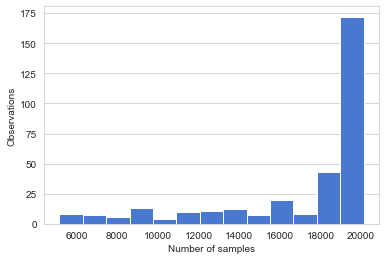

In [4]:
sns.distplot(summary_df.loc[:,'n'], kde = False, hist_kws={'alpha':1.0})
plt.xlabel('Number of samples')
plt.ylabel('Observations')

plt.grid(False, axis = 'x')
#plt.savefig(figure_out_dir + 'Supplemental_Figure_6A_GTEx_TCGA_n_samples.svg')

summary_df.head()

Pearson 0.8673746917732671
Spearman 0.8427349764641666
Number of regressions 145


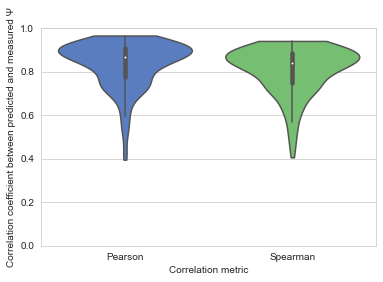

In [5]:
plot_df = performance_df.melt(id_vars =['sample_id'], value_vars = ['pearson_R', 'spearman_R'])
plot_df = plot_df.replace('pearson_R', 'Pearson').replace('spearman_R', 'Spearman')
sns.violinplot(x = 'variable', y = 'value', data = plot_df, cut =0, scale = 'width')

plt.ylim(0,1)
plt.ylabel(u'Correlation coefficient between predicted and measured \u03A8')
plt.xlabel('Correlation metric')
print('Pearson', np.median(performance_df.loc[:,'pearson_R']))
print('Spearman', np.median(performance_df.loc[:,'spearman_R']))
print('Number of regressions', performance_df.shape[0])

#plt.savefig(figure_out_dir + 'Figure_8A_GTEx_TCGA_correlations_test_set.svg')
#plt.savefig(figure_out_dir + 'Figure_8A_GTEx_TCGA_correlations_test_set.png')

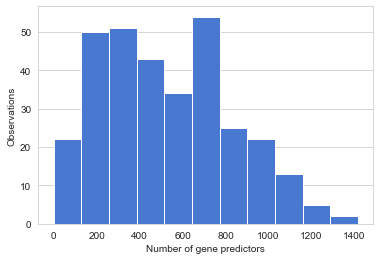

In [6]:
sns.distplot(summary_df.loc[:,'p_trad_genes'], kde = False, hist_kws={'alpha':1.0})
plt.xlabel('Number of gene predictors')
plt.ylabel('Observations')
plt.grid(False, axis = 'x')

#plt.savefig(figure_out_dir + 'Supplemental_Figure_6B_GTEx_TCGA_gene_predictor_hist.svg')

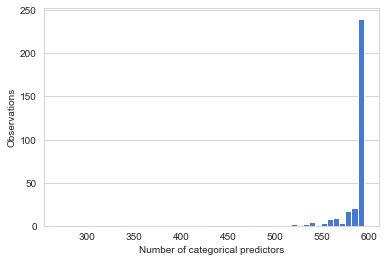

In [7]:
sns.distplot(summary_df.loc[:,'p_dummy'], kde = False, hist_kws={'alpha':1.0})
plt.xlabel('Number of categorical predictors')
plt.ylabel('Observations')
plt.grid(False, axis = 'x')

#plt.savefig(figure_out_dir + 'Supplemental_Figure_6C_GTEx_TCGA_categorical_predictor_hist.svg')

In [8]:
sig_counts = {'up': defaultdict(lambda: 0), 'down': defaultdict(lambda: 0)}
for event in performance_df.loc[:,'sample_id']:
    coef_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'regression_outputs_trad/' + event + '_coefficients.tsv', sep = '\t')
    coef_df['FDR_pval'] = smstats.multitest.multipletests(coef_df.loc[:,'p_val'], method = 'fdr_bh')[1]
    sig_df = coef_df[coef_df.loc[:,'FDR_pval'] <= 0.05]
    up_df = sig_df[sig_df.loc[:,'coefficient'] > 0]
    down_df = sig_df[sig_df.loc[:,'coefficient'] < 0]
    for RBP in list(up_df.loc[:,'variable_id']):
        sig_counts['up'][RBP] += 1
    for RBP in list(down_df.loc[:,'variable_id']):
        sig_counts['down'][RBP] += 1

In [9]:
#From Van Nostrand EL et al., Nature (2020)
ENCODE_SRPs = 'ADAR,AGO2,AKAP8L,BUD13,CCAR2,CCNL1,CDC40,CELF1,DAZAP1,DDX20,DDX5,EFTUD2,ESRP1,EWSR1,FMR1,FUBP1,FUS,GEMIN5,GPKOW,HNRNPA1,HNRNPA2B1,HNRNPC,HNRNPD,HNRNPF,HNRNPH1,HNRNPH2,HNRNPK,HNRNPL,HNRNPLL,HNRNPM,HNRNPU,KHDRBS1,KHDRBS2,KHDRBS3,KHSRP,LSM4,MATR3,MBNL1,MSI1,NCBP2,NONO,NOVA1,PCBP1,PCBP2,PCBP3,PNN,PPIG,PPP1R8,PRPF6,PRPF8,PSIP1,PTBP1,PTBP3,PUF60,QKI,RAVER1,RBFOX2,RBFOX3,RBM14,RBM15,RBM15B,RBM17,RBM22,RBM23,RBM24,RBM25,RBM39,RBM4,RBM47,RBM5,RBM6,SAFB,SF1,SFPQ,SMN1,SND1,SRSF1,SRSF10,SRSF11,SRSF2,SRSF3,SRSF4,SRSF5,SRSF7,SRSF8,SRSF9,STAU1,SUGP2,SYNCRIP,TARDBP,TFIP11,TIA1,TIAL1,TRA2A,U2AF1,U2AF2,ZNF326,ZRANB2'.split(',')


In [10]:
server = Server(host='http://www.ensembl.org')

dataset = (server.marts['ENSEMBL_MART_ENSEMBL']
                 .datasets['hsapiens_gene_ensembl'])

ENSG2name_df = dataset.query(attributes=['ensembl_gene_id', 'external_gene_name'])
ENSG2name = dict(zip(ENSG2name_df.loc[:, 'Gene stable ID'], ENSG2name_df.loc[:, 'Gene name']))

all_vars = sorted(list(set(sig_counts['down']).union(set(sig_counts['up']))))
coefficient_df = pd.DataFrame({'variable_id' : all_vars, 'sig_up': [sig_counts['up'][x] for x in all_vars], 
                               'sig_down': [sig_counts['down'][x] for x in all_vars]})
coefficient_df['gene_name'] = coefficient_df.loc[:,'variable_id'].map(ENSG2name)
coefficient_df = coefficient_df.sort_values('sig_down', ascending = False)

#read in splicing regulatory RBPs from gene ontology
Splicing_regulatory_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'Splicing_regulatory_RBPs_GO0043484.tsv', sep = '\t')


coefficient_df['splicing_regulatory'] = (coefficient_df.loc[:,'gene_name'].isin(Splicing_regulatory_df.loc[:,'Gene_name'])) | (coefficient_df.loc[:,'gene_name'].isin(ENCODE_SRPs))
coefficient_df.head()


,variable_id,sig_up,sig_down,gene_name,splicing_regulatory
2599,tissueBLOOD,29,56,NaN,False
2602,tissueBRAIN,55,47,NaN,False
2620,tissueSPLEEN,18,37,NaN,False
2621,tissueSTOMACH,17,36,NaN,False
2607,tissueHEART,60,35,NaN,False


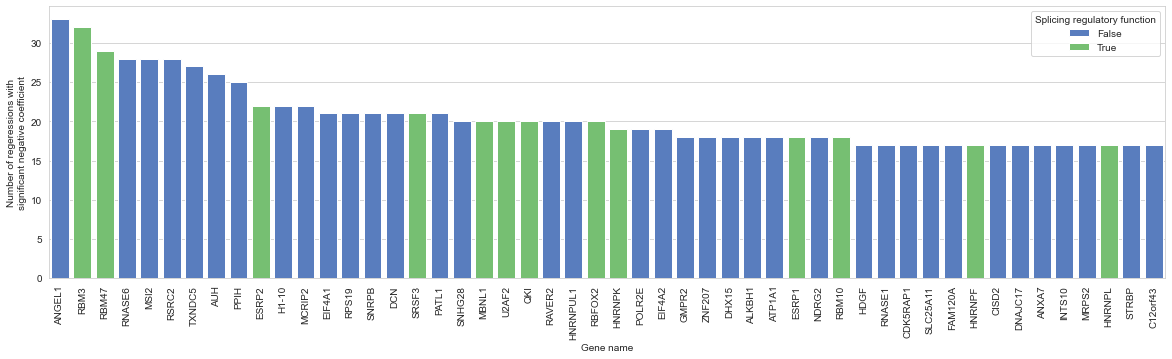

In [11]:
fig,ax = plt.subplots(1,1, figsize = (20,5))
sns.barplot(x = 'gene_name', y = 'sig_down',
            data = coefficient_df[coefficient_df.loc[:,'variable_id'].str.contains('ENSG')].sort_values('sig_down', ascending = False).head(50), hue = 'splicing_regulatory',dodge=False)
plt.xticks(rotation=90)
plt.ylabel('Number of regeressions with\nsignificant negative coefficient')
plt.xlabel('Gene name')
plt.legend(title = 'Splicing regulatory function')
#plt.savefig(figure_out_dir + 'Figure_8B_GTEx_TCGA_negative_coefficients.svg')
#plt.savefig(figure_out_dir + 'Figure_8B_GTEx_TCGA_negative_coefficients.png')
plt.show()

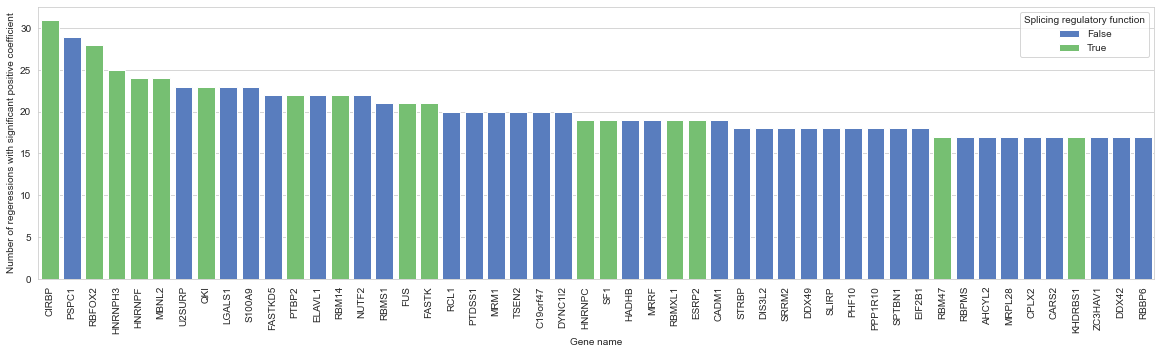

In [12]:
fig,ax = plt.subplots(1,1, figsize = (20,5))
sns.barplot(x = 'gene_name', y = 'sig_up',
            data = coefficient_df[coefficient_df.loc[:,'variable_id'].str.contains('ENSG')].sort_values('sig_up', ascending = False).head(50),
            hue = 'splicing_regulatory', dodge=False)
plt.xticks(rotation=90)
plt.ylabel('Number of regeressions with significant positive coefficient')
plt.xlabel('Gene name')
plt.legend(title = 'Splicing regulatory function')
#plt.savefig(figure_out_dir + 'Figure_8C_GTEx_TCGA_positive_coefficients.svg')
#plt.savefig(figure_out_dir + 'Figure_8C_GTEx_TCGA_positive_coefficients.png')
plt.show()

In [13]:
sig_pred = defaultdict(lambda:0); any_pred = defaultdict(lambda:0)
for event in performance_df.loc[:,'sample_id']:
    RBP = event.split('_')[0]
    coef_df = pd.read_csv(base_dir + 'preprocessed_data/' + 'regression_outputs_trad/' + event + '_coefficients.tsv', sep = '\t')
    coef_df['FDR_pval'] = smstats.multitest.multipletests(coef_df.loc[:,'p_val'], method = 'fdr_bh')[1]
    sig_df = coef_df[coef_df.loc[:,'FDR_pval'] <=0.05]
    sig_df['Gene_name'] = sig_df.loc[:,'variable_id'].map(ENSG2name)
    if RBP in list(sig_df.loc[:,'Gene_name']):
        sig_pred[RBP] += 1
    any_pred[RBP] += 1
    
pred_df = pd.DataFrame({'RBP': list(any_pred), 'sig_count': [sig_pred[RBP] for RBP in list(any_pred)],
                        'total_count': [any_pred[RBP] for RBP in list(any_pred)]})


Percent SREs significant predictors 28.96551724137931


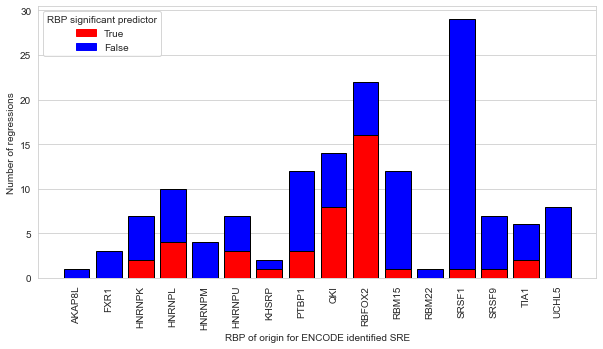

In [14]:
fig, ax = plt.subplots(1,1, figsize = (10,5))

#how many of the SREs that we identified in ENCODE, and studied with Vex-seq validate through expression dependence?
ax.bar(list(pred_df.index), height = pred_df.loc[:,'sig_count'], color = 'red', edgecolor = 'black')
ax.bar(list(pred_df.index), height = pred_df.loc[:,'total_count'] - pred_df.loc[:,'sig_count'], 
        bottom = pred_df.loc[:,'sig_count'], color = 'blue', edgecolor = 'black')
plt.xticks(ticks = list(pred_df.index), labels = pred_df.loc[:,'RBP'], rotation = 90)
plt.ylabel('Number of regressions')
plt.xlabel('RBP of origin for ENCODE identified SRE')

print('Percent SREs significant predictors', pred_df.loc[:,'sig_count'].sum() *100 / pred_df.loc[:,'total_count'].sum())
legend_TN = [patches.Patch(color = 'red', label = 'True'), patches.Patch(color = 'blue', label = 'False')]
ax.legend(title = 'RBP significant predictor', loc='upper left', handles=legend_TN,frameon=True)
plt.grid(False, axis = 'x')

#plt.savefig(figure_out_dir + 'Figure_8D_GTEx_TCGA_SRE_predictors.svg')
#plt.savefig(figure_out_dir + 'Figure_8D_GTEx_TCGA_SRE_predictors.png')